# Typing systems

Python is a dynamically typed language.
This means that the types of the objects used in a Python program is found at run-time.
While this speeds up software development iterations, which makes programming error prone.

To address this issue, Python has a number of optional static typing systems.
These systems allow the programmer to specify the types of variables and function arguments.
The Python interpreter can then check that the program is consistent with the types specified by the programmer.
This allows the interpreter to catch a number of programming errors at compile time.
Type hints in Python look like this:
```python
def add(x: int, y: int) -> int:
    return x + y
```

Functions in `jax` are explained in the documentation using Haskell-like type signatures.
These type signatures look like this:
```haskell
add :: a -> b -> c
```

Understanding about types and being familiar with Haskell-like type signatures will make it easier to understand the documentation for `jax`.

## Haskell's Type System

Haskell has a strong static type system. This means that all functions are pure and all types are known at compile time.
`jax` authors use Hakell type notation in their documentation.

### Primitive Types
The primitive types in Haskell are:
- `Int`
- `Bool`
- `Char`
- `Double`
- `Float`

### Composite Types

Lists are a _generic_ or _parametric_ type in Haskell.
There type is written as `[T]`, where `T` is the type of the elements in the list.
List of lists are written as `[[T]]`, and list of lists of lists are written as `[[[T]]]`, and so on.

### Function Types
The type of functions is written as `T -> U`, where `T` and `U` are type variables which can be replaced by any type.

For example, a function that takes an `Int` and returns a `Bool` has type `Int -> Bool`.
```haskell
f :: Int -> Bool
```

A function that takes a list of floats and returns a float can be typed as
```haskell
g :: [Float] -> Float
```

A function that takes a list of type `T` and return a result of the same type `T` can be typed as
```haskell
h :: [T] -> T
```

This is called a _polymorphic_ function. It is a function that can be applied to arguments of any type.

### Curried Function


## Types of higher order functions
Let us write our some type signatures for some higher order functions.

```haskell
map :: (a -> b) -> [a] -> [b]
```

```haskell
filter :: (a -> Bool) -> [a] -> [a]
```

```haskell
compose:: (b -> c) -> (a -> b) -> a -> c
```

for `jax.vmap` we have
```haskell
vmap::(a -> b) -> ([a] -> [b])
```

for `jax.fori_loop` we have the following Python analog
```python
def fori_loop(lower, upper, body_fun, init_val):
  val = init_val
  for i in range(lower, upper):
    val = body_fun(i, val)
  return val
```

We can type this function as follows,
```haskell
fori_loop::Int -> Int -> (Int -> a -> a) -> a -> a
```

Signature of `jax.grad`

```haskell
grad:: ([a] -> a) -> ([a] -> [a])
```

Signature of `jax.jacobian`

```haskell
jacobian:: ([a] -> [a]) -> ([a] -> [[a]])
```

Signature of `jax.hessian`

```haskell
hessian:: ([a] -> a) -> ([a] -> [[a]])
```

Signature of `jax.jvp`
```haskell
jvp:: ([a] -> a) -> [a] -> [a] -> [a]
```

# Pytrees to represent model parameters

Definition of a PyTree
> In Jax, we use the term pytree to refer to a tree-like structure built out of container-like Python objects. Classes are considered container-like if they are in the pytree registry, which include built-in container types like list, tuples, and dicts. That is: any object whose type is not in the pytree container registry is considered a leaf pytreel any object whose type is in the pytree container registry, and which contains pytrees, it considered a pytree.

Let's see some examples below

In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as tree_util

x = jnp.array([1, 2, 3])
x

Array([1, 2, 3], dtype=int32)

In [2]:
tree_util.tree_structure(x)

PyTreeDef(*)

In [3]:
tree = (1, x, 'hello')
tree_util.tree_structure(tree)

PyTreeDef((*, *, *))

In [4]:
tree = [1, x, 'hello']
tree_util.tree_structure(tree)

PyTreeDef([*, *, *])

In [5]:
tree = {'a': 1, 'b': x, 'c': 'hello'}
tree_util.tree_structure(tree)

PyTreeDef({'a': *, 'b': *, 'c': *})

In [6]:
tree = {'tree1': {'a': 1, 'b': x, 'c': 'hello'},
        'tree2': {'a': 1, 'b': (x, x, x), 'c': 'hello'}}

In [7]:
tree

{'tree1': {'a': 1, 'b': Array([1, 2, 3], dtype=int32), 'c': 'hello'},
 'tree2': {'a': 1,
  'b': (Array([1, 2, 3], dtype=int32),
   Array([1, 2, 3], dtype=int32),
   Array([1, 2, 3], dtype=int32)),
  'c': 'hello'}}

In [8]:
tree_util.tree_structure(tree)

PyTreeDef({'tree1': {'a': *, 'b': *, 'c': *}, 'tree2': {'a': *, 'b': (*, *, *), 'c': *}})

The leaves of the pytree are the primitives, the arrays and the tuples of primitives and arrays.
They are shown by `*` above.
You can get the leaves of a pytree as a flattened list with `jax.tree_leaves`:

In [9]:
tree_util.tree_leaves(tree)

[1,
 Array([1, 2, 3], dtype=int32),
 'hello',
 1,
 Array([1, 2, 3], dtype=int32),
 Array([1, 2, 3], dtype=int32),
 Array([1, 2, 3], dtype=int32),
 'hello']

You can also flatten the tree with `jax.tree_flatten`.
It returns a tuple of the leaves and a function that can reconstruct the tree from the leaves.

In [10]:
flat_values, tree_type = tree_util.tree_flatten(tree)
flat_values

[1,
 Array([1, 2, 3], dtype=int32),
 'hello',
 1,
 Array([1, 2, 3], dtype=int32),
 Array([1, 2, 3], dtype=int32),
 Array([1, 2, 3], dtype=int32),
 'hello']

In [11]:
tree_util.tree_unflatten(tree_type, flat_values)

{'tree1': {'a': 1, 'b': Array([1, 2, 3], dtype=int32), 'c': 'hello'},
 'tree2': {'a': 1,
  'b': (Array([1, 2, 3], dtype=int32),
   Array([1, 2, 3], dtype=int32),
   Array([1, 2, 3], dtype=int32)),
  'c': 'hello'}}

## Example: Neural network parameters

The most useful type of pytree for us is the one that contains `jax` arrays.
This is the structure that we will use to represent the parameters of our neural networks.
Let's make a simple neural network by hand, using a dictionary to represent the parameters of the network.

In [12]:
from jax import vmap
from functools import partial

@partial(vmap, in_axes=(0, None))
def simple_nn(x, params):
    W1 = params["layer1"]["W"]
    b1 = params["layer1"]["b"]
    W2 = params["layer2"]["W"]
    b2 = params["layer2"]["b"]
    return W2 @ jnp.tanh(W1 @ x + b1) + b2

In [13]:
import jax.random as random

key = random.PRNGKey(0)
keys = random.split(key, 4)

params = {
    "layer1": {
        "W": random.normal(keys[0], (2, 3)),
        "b": random.normal(keys[1], (2,)),
    },
    "layer2": {
        "W": random.normal(keys[2], (1, 2)),
        "b": random.normal(keys[3], (1,)),
    },
}
params

{'layer1': {'W': Array([[-0.11168969,  0.58439565,  1.437887  ],
         [ 0.533231  , -1.0117726 , -2.316002  ]], dtype=float32),
  'b': Array([-1.5917008, -0.9385306], dtype=float32)},
 'layer2': {'W': Array([[ 0.43686673, -0.5115205 ]], dtype=float32),
  'b': Array([0.6714109], dtype=float32)}}

In [14]:
key, subkey = random.split(keys[0])
xs = random.normal(subkey, (10, 3))

simple_nn(xs, params)

Array([[ 0.6350196 ],
       [ 0.3767303 ],
       [ 0.7132992 ],
       [ 0.88301647],
       [-0.27681673],
       [-0.17706287],
       [-0.22115844],
       [ 0.31149212],
       [ 1.293994  ],
       [ 0.97846043]], dtype=float32)

In [15]:
key, subkey = random.split(key)
ys = random.normal(subkey, (10,))

def loss(params, xs, ys):
    pred = simple_nn(xs, params)
    return jnp.mean((pred - ys) ** 2)

In [16]:
loss(params, xs, ys)

Array(1.9756663, dtype=float32)

In [17]:
from jax import grad, jit

grad_loss = jit(grad(loss))

In [18]:
g = grad_loss(params, xs, ys)
g

{'layer1': {'W': Array([[-0.12261432, -0.06746285,  0.25431654],
         [ 0.05320146, -0.02407618,  0.04390811]], dtype=float32),
  'b': Array([ 0.2712015, -0.1596887], dtype=float32)},
 'layer2': {'W': Array([[-0.6151127, -1.058177 ]], dtype=float32),
  'b': Array([1.1982161], dtype=float32)}}

In [19]:
tree_util.tree_structure(g)

PyTreeDef({'layer1': {'W': *, 'b': *}, 'layer2': {'W': *, 'b': *}})

The parameters are a pytree, so the gradient is a pytree too.
The structure of the pytree is the same as the structure of the parameters.
The leaves of the `g` pytree are the gradients of the loss function w.r.t the parameters.
This generalizes to any pytree, not just dictionaries.

We can do a gradient descent on them.
We have to subtract a small multiple of the gradient from the parameters.


In [20]:
new_params = tree_util.tree_map(
    lambda theta, delta_theta: theta - 0.1 * delta_theta,
    params,
    g
)

new_params

{'layer1': {'W': Array([[-0.09942825,  0.59114194,  1.4124553 ],
         [ 0.5279109 , -1.009365  , -2.3203926 ]], dtype=float32),
  'b': Array([-1.6188209 , -0.92256176], dtype=float32)},
 'layer2': {'W': Array([[ 0.498378 , -0.4057028]], dtype=float32),
  'b': Array([0.5515893], dtype=float32)}}

The function `tree_map` apploes a function to every leaf of a pytree.

Now, if we wanted to add a L2 regularization term to the loss function. This means that we have to add the square of every parameter to the loss function.

In [21]:
params2 = tree_util.tree_map(
    lambda x: x**2,
    params
)

# and sum the squares using `tree_reduce`:
tree_util.tree_reduce(
    lambda x, y: jnp.sum(x) + jnp.sum(y),
    params2,
    0.0
)

Array(13.411044, dtype=float32)

In [22]:
# Rewrite the loss function to include the regularization

def loss(params, xs, ys):
    pred = simple_nn(xs, params)
    squared_error = jnp.mean((pred - ys) ** 2)
    l2_norm = tree_util.tree_reduce(
        lambda x, y: jnp.sum(x) + jnp.sum(y),
        tree_util.tree_map(lambda x: x**2, params),
        0.0
    )
    return squared_error + 0.1 * l2_norm

Introducing another useful funtion, `value_and_grad`.
It returns the value of a functoin and its gradient.

In [23]:
from jax import value_and_grad

loss_and_grad = jit(value_and_grad(loss))

v, g = loss_and_grad(params, xs, ys)

In [24]:
v

Array(3.3167708, dtype=float32)

In [25]:
g

{'layer1': {'W': Array([[-0.14495225,  0.04941629,  0.54189396],
         [ 0.15984766, -0.22643071, -0.41929227]], dtype=float32),
  'b': Array([-0.04713867, -0.34739482], dtype=float32)},
 'layer2': {'W': Array([[-0.52773935, -1.1604811 ]], dtype=float32),
  'b': Array([1.3324983], dtype=float32)}}

## Named tuples

Named tuples are useful to represent data.
Namedtuples are also pytrees.

In [26]:
from collections import namedtuple

NNParameters = namedtuple("NNParameters", ["layer1", "layer2"])
LayerParameters = namedtuple("LayerParameters", ["W", "b"])

params = NNParameters(
    LayerParameters(
        W=random.normal(keys[0], (2, 3)),
        b=random.normal(keys[1], (2,)),
    ),
    LayerParameters(
        W=random.normal(keys[2], (1, 2)),
        b=random.normal(keys[3], (1,)),
    ),
)
params

NNParameters(layer1=LayerParameters(W=Array([[-0.11168969,  0.58439565,  1.437887  ],
       [ 0.533231  , -1.0117726 , -2.316002  ]], dtype=float32), b=Array([-1.5917008, -0.9385306], dtype=float32)), layer2=LayerParameters(W=Array([[ 0.43686673, -0.5115205 ]], dtype=float32), b=Array([0.6714109], dtype=float32)))

In [27]:
params.layer1

LayerParameters(W=Array([[-0.11168969,  0.58439565,  1.437887  ],
       [ 0.533231  , -1.0117726 , -2.316002  ]], dtype=float32), b=Array([-1.5917008, -0.9385306], dtype=float32))

In [28]:
params.layer1.W

Array([[-0.11168969,  0.58439565,  1.437887  ],
       [ 0.533231  , -1.0117726 , -2.316002  ]], dtype=float32)

In [29]:
tree_util.tree_structure(params)

PyTreeDef(CustomNode(namedtuple[NNParameters], [CustomNode(namedtuple[LayerParameters], [*, *]), CustomNode(namedtuple[LayerParameters], [*, *])]))

In [30]:
tree_util.tree_map(lambda x: x**2, params)

NNParameters(layer1=LayerParameters(W=Array([[0.01247459, 0.34151828, 2.067519  ],
       [0.28433532, 1.0236839 , 5.363865  ]], dtype=float32), b=Array([2.5335114, 0.8808397], dtype=float32)), layer2=LayerParameters(W=Array([[0.19085254, 0.2616532 ]], dtype=float32), b=Array([0.4507926], dtype=float32)))

In [31]:
@partial(vmap, in_axes=(0, None))
def simple_nn(x, params):
    W1 = params.layer1.W
    b1 = params.layer1.b
    W2 = params.layer2.W
    b2 = params.layer2.b
    return W2 @ jnp.tanh(W1 @ x + b1) + b2

@jit
@value_and_grad
def loss(params, xs, ys):
    pred = simple_nn(xs, params)
    squared_error = jnp.mean((pred - ys) ** 2)
    l2_norm = tree_util.tree_reduce(
        lambda x, y: jnp.sum(x) + jnp.sum(y),
        tree_util.tree_map(lambda x: x**2, params),
        0.0
    )
    return squared_error + 0.1 * l2_norm

loss(params, xs, ys)

(Array(3.3167708, dtype=float32),
 NNParameters(layer1=LayerParameters(W=Array([[-0.14495225,  0.04941629,  0.54189396],
        [ 0.15984766, -0.22643071, -0.41929227]], dtype=float32), b=Array([-0.04713867, -0.34739482], dtype=float32)), layer2=LayerParameters(W=Array([[-0.52773935, -1.1604811 ]], dtype=float32), b=Array([1.3324983], dtype=float32))))

## Equinox - How to actually do this in practice?

We don't want to write our neural networks by hand.

- Flax
- Haiku
- Equinox

Equinox relies only on `Pytrees`.
`Equinox` will be used in this course.

In [32]:
import equinox as eqx

class SimpleNN(eqx.Module):
    layers: list

    def __init__(self, n_inputs, n_hidden, n_outputs, key):
        key1, key2 = random.split(key)
        self.layers = [
            eqx.nn.Linear(n_inputs, n_hidden, key=key1),
            eqx.nn.Linear(n_hidden, n_outputs, key=key2),
        ]
    # We can neatly vectorize the forward pass
    # Here we need to in_axes=(0, None) because the first argument is `self`
    @partial(vmap, in_axes=(None, 0))
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jnp.tanh(layer(x))
        return self.layers[-1](x)


In [33]:
key = random.PRNGKey(314)
model = SimpleNN(3, 2, 1, key)
model

SimpleNN(
  layers=[
    Linear(
      weight=f32[2,3],
      bias=f32[2],
      in_features=3,
      out_features=2,
      use_bias=True
    ),
    Linear(
      weight=f32[1,2],
      bias=f32[1],
      in_features=2,
      out_features=1,
      use_bias=True
    )
  ]
)

In [34]:
print(xs.shape)
model(xs)

(10, 3)


Array([[-0.26482067],
       [-0.17487162],
       [-0.28958413],
       [-0.34640497],
       [-0.10561763],
       [-0.12498382],
       [-0.26911202],
       [-0.24482018],
       [-0.36088067],
       [-0.21855468]], dtype=float32)

In [35]:
tree_util.tree_structure(model)

PyTreeDef(CustomNode(SimpleNN[('layers',), (), ()], [[CustomNode(Linear[('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (3, 2, True)], [*, *]), CustomNode(Linear[('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (2, 1, True)], [*, *])]]))

In [36]:
# go to specific parameters like so
model.layers[0].weight

Array([[-0.48662117,  0.08805605,  0.25260752],
       [ 0.55680007, -0.21773158, -0.5048137 ]], dtype=float32)

In [37]:
# or all together (but without names)
tree_util.tree_leaves(model)

[Array([[-0.48662117,  0.08805605,  0.25260752],
        [ 0.55680007, -0.21773158, -0.5048137 ]], dtype=float32),
 Array([-0.04204372, -0.52129227], dtype=float32),
 Array([[-0.42024657, -0.18588884]], dtype=float32),
 Array([-0.30617577], dtype=float32)]

In [38]:
# or you can organize a separate pytree
eqx.tree_flatten_one_level(model)

([[Linear(
     weight=f32[2,3],
     bias=f32[2],
     in_features=3,
     out_features=2,
     use_bias=True
   ),
   Linear(
     weight=f32[1,2],
     bias=f32[1],
     in_features=2,
     out_features=1,
     use_bias=True
   )]],
 PyTreeDef(CustomNode(SimpleNN[('layers',), (), ()], [*])))

In [39]:
# But think of the model and its parameters as a single object
# Here is how to compute the L2 norm of the parameters
tree_util.tree_reduce(
    lambda x, y: jnp.sum(x) + jnp.sum(y),
    tree_util.tree_map(lambda x: x**2, model),
    0.0
)

Array(1.4990535, dtype=float32)

In [40]:
# making our loss function
@jit
@value_and_grad
def loss(model, xs, ys):
    pred = model(xs)
    squared_error = jnp.mean((pred - ys) ** 2)
    l2_norm = tree_util.tree_reduce(
        lambda x, y: jnp.sum(x) + jnp.sum(y),
        tree_util.tree_map(lambda x: x**2, model),
        0.0
    )
    return squared_error + 0.1 * l2_norm

In [41]:
# note that the gradient w.r.t `model` which is identified with its parameters
# Here is how it looks like:
v, g = loss(model, xs, ys)
v

Array(1.5138841, dtype=float32)

In [42]:
g

SimpleNN(
  layers=[
    Linear(
      weight=f32[2,3],
      bias=f32[2],
      in_features=3,
      out_features=2,
      use_bias=True
    ),
    Linear(
      weight=f32[1,2],
      bias=f32[1],
      in_features=2,
      out_features=1,
      use_bias=True
    )
  ]
)

In [43]:
tree_util.tree_leaves(g)

[Array([[-0.1455418 ,  0.03308565,  0.05444702],
        [ 0.09960934, -0.03814673, -0.10497998]], dtype=float32),
 Array([ 0.06236227, -0.08787652], dtype=float32),
 Array([[-0.15165785,  0.11073178]], dtype=float32),
 Array([-0.24634382], dtype=float32)]

## Autograd with `jax`

Important features of `jax` that are required for the course is covered here:

In [44]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from functools import partial

# vectorized for the centers
@partial(vmap, in_axes=(None, 0, None))
def rbf_basis(x, c, sigma2):
    # jax.debug.print("shape of x: {}".format(x.shape))
    # jax.debug.print("shape of c: {}".format(c.shape))
    # jax.debug.print("shape of (x-c) : {}".format((x-c).shape))
    return jnp.exp(-jnp.sum((x-c)**2, axis=-1) / sigma2)

In [53]:
@jit
@partial(vmap, in_axes=(0, None, None, None), out_axes=0)
def model(x, w, c, sigma2):
    # return w @ rbf_basis(x, c, sigma2)
    return jnp.dot(rbf_basis(x, c, sigma2), w).reshape(-1)

In [54]:
import jax.random as random

sigma2 = 0.01
c = jnp.linspace(-1, 1, 10).reshape(-1, 1)
key = random.PRNGKey(0)
key, subkey = random.split(key)
w = random.normal(subkey, (10,))
x = jnp.linspace(-1, 1, 100).reshape(-1, 1)

y = model(x, w, c, sigma2)
print(rbf_basis(x, c, sigma2).shape)
print(y.shape)

(10, 100)
(100, 1)


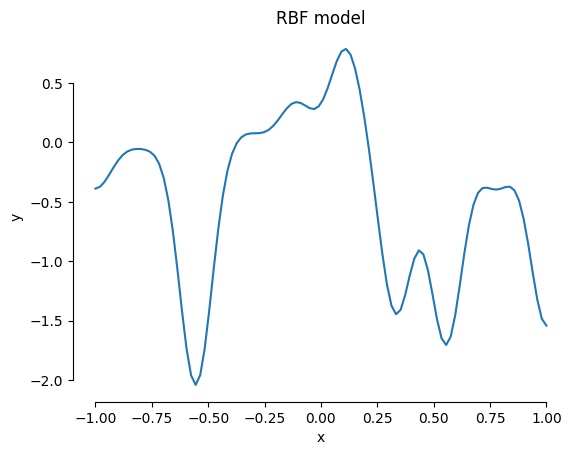

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax.plot(x, y, label='model')
ax.set(xlabel='x', ylabel='y', title='RBF model')
sns.despine(trim=True);

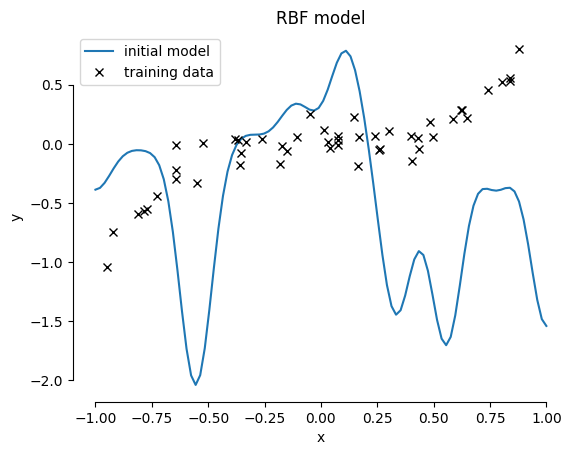

In [56]:
## Adding data to set up sum of squared error loss
key, subkey = random.split(key)
x_train = random.uniform(subkey, (50, 1), minval=-1, maxval=1)
key, subkey = random.split(key)
y_train = x_train**3 + 0.1 * random.normal(subkey, (50, 1))

fig, ax = plt.subplots()
ax.plot(x, y, label="initial model")
ax.plot(x_train, y_train, 'kx', label="training data")
ax.set(xlabel='x', ylabel='y', title='RBF model')
plt.legend()
sns.despine(trim=True);

In [58]:
def loss(w, c, sigma2, x, y):
    y_pred = model(x, w, c, sigma2)
    return jnp.mean((y_pred - y)**2)

In [64]:
loss_grad = jit(grad(loss, argnums=0))

In [65]:
loss_grad(w, c, sigma2, x_train, y_train)

Array([-1.0574479 , -0.38118002,  0.26727194, -0.7237114 , -1.0403341 ,
       -1.080807  ,  0.4755785 ,  0.7723094 ,  0.6198999 , -0.87638605],      dtype=float32)

In [66]:
full_loss_grad = jit(grad(loss, argnums=(0, 1, 2)))

In [67]:
w_grad, c_grad, sigma2_grad = full_loss_grad(w, c, sigma2, x_train, y_train)
print(w_grad.shape, c_grad.shape, sigma2_grad.shape)

(10,) (10, 1) ()


In [68]:
# Naive implementation of a gradient descent
@jit
def gd_step(w, c, sigma2, x, y, lr=0.1):
    w_grad = loss_grad(w, c, sigma2, x, y)
    w = w - lr * w_grad
    return w, c, sigma2

num_iter = 10_000
lr = 0.01
n_batch = 10

w = random.normal(key, (10,))
c = random.uniform(key, (10, 1), minval=-1, maxval=1)
sigma2 = 0.1

for i in range(num_iter):
    w, c, sigma2 = gd_step(w, c, sigma2, x_train, y_train, lr=lr)

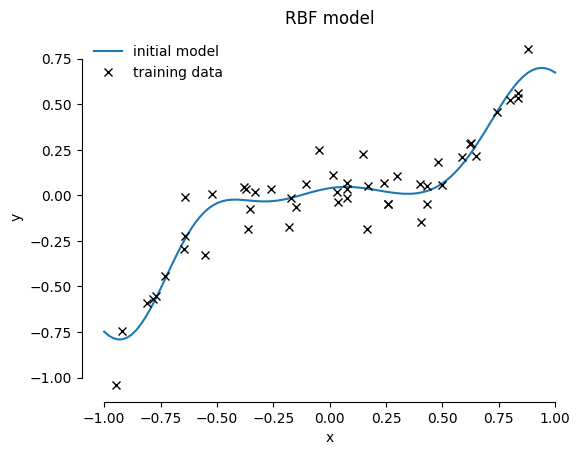

In [69]:
pred = model(x, w, c, sigma2)

fig, ax = plt.subplots()
ax.plot(x, pred, label='initial model')
ax.plot(x_train, y_train, 'kx', label='training data')
ax.set(xlabel='x', ylabel='y', title='RBF model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);